# ARIMA (SARIMA)

The script aims to forecast the values of a time series using an ARIMA (or SARIMA) model. The series in question, which can be found on this [link](https://www3.bcb.gov.br/sgspub/consultarvalores/telaCvsSelecionarSeries.paint) represents the Retail Sales Volume Index in the state of São Paulo, Brazil, with monthly data from 2000 to 2022.

The model will be trained using the data up to December 2020 and then be capable of making predictions for the years 2021 and 2022.

The chosen evaluation metric is MAPE (Mean Absolute Percentage Error), which is commonly used to evaluate forecasts in time series. MAPE is calculated as the average of the absolute percentage differences between actual and predicted values relative to actual values.

The formula for MAPE is given by:

$MAPE = \large\frac{1}{n}\small * ∑\large|\large\frac{(Yi - Pi)}{Yi}|\small * 100$

Where:

- n is the number of observations
- $Y_i$ is the actual value of observation i
- $P_i$ is the predicted value of observation i

## Implementation

- Check the dataset for patterns of trend and seasonality.


- Test the stationarity of the data using the Dickey-Fuller test.



- Create and train the model.


- Obtain the forecasts.



- Analyze the obtained results (outputs).

***

## Checking Dataset

In [1]:
# Libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
import datetime as dt
import warnings

warnings.filterwarnings("ignore")
sns.set()

In [2]:
# Checking the data
df_retail = pd.read_csv(f'Data/retailsp.csv', index_col=0)
df_retail.head(5)

,value,Date
0,45.40,2000-01-01
1,46.52,2000-02-01
2,49.11,2000-03-01
3,47.99,2000-04-01
4,50.15,2000-05-01


In [3]:
# Transforming the Date column
df_retail['Date'] = pd.to_datetime(df_retail['Date'])

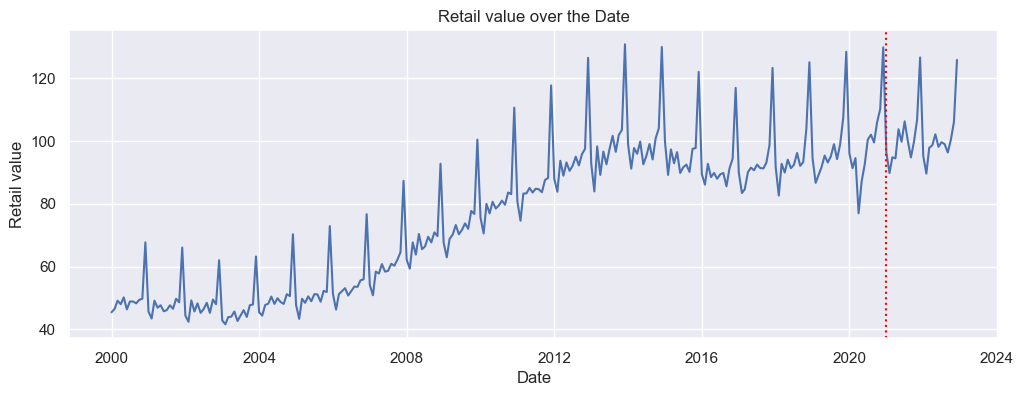

In [4]:
# Plotting the Retail Value over the Date
plt.figure(figsize=(12,4))
plt.plot(df_retail['Date'], df_retail['value'])
plt.xlabel('Date')
plt.ylabel('Retail value')
plt.title('Retail value over the Date')
plt.axvline(dt.datetime(2021, 1, 1), color='red', linestyle='dotted')
plt.show();

The dotted line indicates the point at which the forecasts will begin to be made.

By looking at the plot, it is clearly evident that there is a seasonal pattern in the data (which would indicate that the SARIMA model should be used instead of ARIMA). However, it might be interesting to perform a double-check by decomposing the series.

In [5]:
# Decomposing
decomposed_ts = sm.tsa.seasonal_decompose(df_retail['value'], period=12)

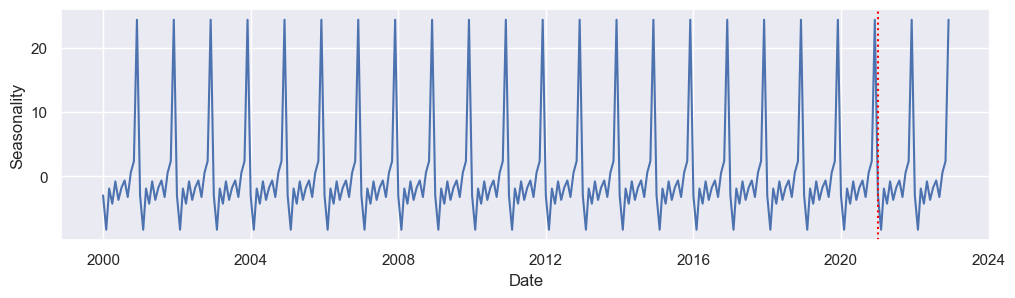

In [6]:
# Plotting the Seasonality
plt.figure(figsize=(12,3))
plt.plot(df_retail['Date'], decomposed_ts.seasonal)
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.axvline(dt.datetime(2021, 1, 1), color='red', linestyle='dotted')
plt.show();

Decomposing the time series makes it even clearer that there is a seasonal component influencing the series on an annual basis, and this information should be considered in the model construction.

## Verifying stationarity

A stationary time series is one in which the statistical properties, such as mean, variance, and autocorrelation, do not change over time. In other words, the series maintains a consistent pattern and is not affected by trends, seasonality, or abrupt changes. A traditional ARIMA model can only be applied to stationary series, but the 'auto_arima' model used (from the 'pmdarima' package) will preprocess the data, automatically applying differencing if the data is non-stationary.

One way to test the stationarity of a series is by using the Dickey-Fuller test. This test helps determine whether a series is stationary by examining the presence of unit roots. If the test results in a p-value below a certain significance level (e.g., 0.05), it suggests that the series is stationary. Conversely, a p-value above the significance level indicates that the series is non-stationary and usually requires further treatment, such as differencing, to achieve stationarity.


In [7]:
# Dickey Fuller Test
adf_result = adfuller(df_retail['value'], maxlag=1)
adf_result

(-2.7477882845169717,
 0.06612753056152,
 1,
 274,
 {'1%': -3.4544435065994437,
  '5%': -2.8721468827772774,
  '10%': -2.572422013959188},
 2052.9793247884845)

The second value in the print is the p-value, which, being greater than 0.05, does not reject the null hypothesis, indicating that the series, under a 5% significance level, is stationary.

## Create and train the model

It will be necessary to split the series into training and testing sets. This is done to create and adjust the model and later make predictions that can be compared with the original values.

In [8]:
# Getting the last value index
idx_split = df_retail.loc[df_retail['Date']==dt.datetime(2020,12,1)].index[0]

In [9]:
# Splitting the train and test values
train_values = df_retail[0:idx_split]
test_values = df_retail[idx_split:]

The model will be created using the auto_arima function, which performs an automatic search to determine the best parameters for the ARIMA model based on the training data. The 'trace' parameter is set to True to display information about the model.

The seasonal parameter, previously mentioned, should be added to the function, and 'm=12' sets the seasonal periodicity as 12, indicating an annual seasonality.

In [10]:
# Creating the model
arima_model = auto_arima(train_values['value'], trace=True, seazonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1115.466, Time=0.45 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1197.921, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1140.595, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1118.617, Time=0.10 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1113.714, Time=0.40 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(2,1,2)(0,1,2)[12]             : AIC=1115.573, Time=1.00 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1115.704, Time=0.42 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=1117.694, Time=1.98 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1111.793, Time=0.34 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=1113.530, Time=0.44 sec
 ARIMA(1,1,2)(0,1,2)[12]             : AIC=1113.641, Time=0.81 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=1113.827, Time=0.39 sec
 ARIMA(1,1,2)(1,1,2)[12]     

The output indicates that the best model identified by the 'auto_arima' algorithm is an ARIMA(1,1,2)(0,1,1)[12] model. This notation represents the order of the components in the ARIMA model: (p, d, q)(P, D, Q)[s]. In this case, we have:

- p = 1: order of the autoregressive component (AR).
- d = 1: order of differencing.
- q = 2: order of the moving average component (MA).
- P = 0: order of the seasonal autoregressive component.
- D = 1: order of seasonal differencing.
- Q = 1: order of the seasonal moving average component.
- s = 12: seasonal period (12 months).

These parameters were determined to be the most suitable for fitting the training data based on the Akaike Information Criterion (AIC).

After identifying the best ARIMA model, the model will be fitted or trained using the training data.

In [11]:
# Fit
arima_model.fit(train_values['value'])

ARIMA(order=(1, 1, 2), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [12]:
# Model Outputs
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  251
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -550.897
Date:                              Tue, 06 Jun 2023   AIC                           1111.793
Time:                                      15:59:21   BIC                           1129.155
Sample:                                           0   HQIC                          1118.790
                                              - 251                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8401      0.059    -14.124      0.000      -0.957      -0.724
ma.L1          0.4102      0.064      6.420      0.000       0.285       0.535
ma.L2         -0.5357      0.055     -9.739      0.000      -0.643      -0.428
ma.S.L12      -0.3912      0.087     -4.520      0.000      -0.561      -0.222
sigma2         5.9149      0.219     27.006      0.000       5.486       6.344
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1936.80
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               5.98   Skew:                            -1.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Making predictions and nalyzing the results

The now fitted model will make predictions corresponding to the size of the test data.

In [13]:
# Predictions
y_pred = arima_model.predict(n_periods=len(test_values))

In [14]:
y_pred[0:5]

251    133.400245
252    100.675763
253     95.582360
254     98.542036
255     88.912731
dtype: float64

The predictions generated by the model will be compared to the actual values using the MAPE metric, which is a commonly used measure to evaluate the accuracy of forecasts in time series.

In [15]:
# Predicted and real values
df_test = df_retail.loc[idx_split+1:]
df_test['predicted_value'] = y_pred
df_test[['Date', 'value', 'predicted_value']]

,Date,value,predicted_value
252,2021-01-01,96.35,100.675763
253,2021-02-01,89.82,95.582360
254,2021-03-01,94.83,98.542036
255,2021-04-01,94.51,88.912731
256,2021-05-01,103.80,95.919634
257,2021-06-01,99.80,98.838323
258,2021-07-01,106.32,103.894144
259,2021-08-01,100.18,106.417703
260,2021-09-01,94.80,103.038940
261,2021-10-01,99.77,108.588962


In [16]:
# Getting MAPE
print(f"MAPE: {round((np.mean(abs((df_test['value'] - df_test['predicted_value'])/df_test['value']))),4) * 100}% ")

MAPE: 7.22% 


A MAPE of 7.22% indicates that, on average, the model's predictions have a mean absolute percentage error of 7.22% compared to the actual values in the training dataset. A lower MAPE value indicates better model performance, as it indicates that the predictions are closer to the actual values. Therefore, a MAPE of 7.22% is considered a positive result, indicating good accuracy in the predictions.

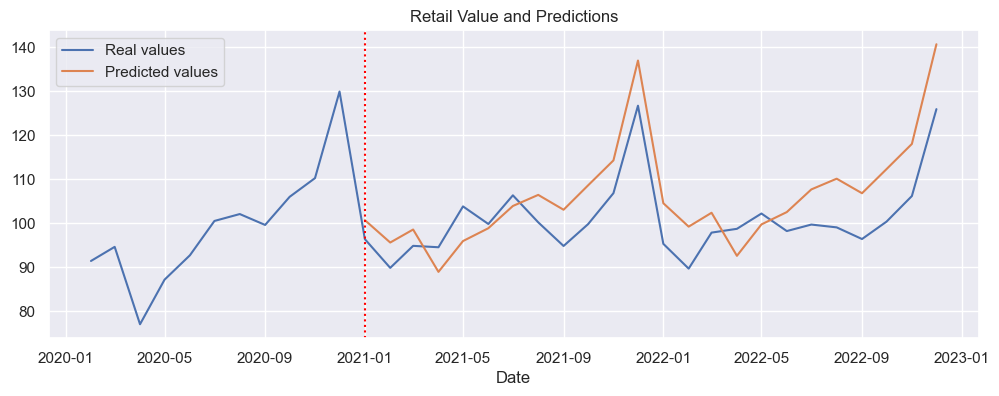

In [17]:
# Plotting the Retail Value and predictions after 2020
plt.figure(figsize=(12,4))
plt.plot(df_retail['Date'].loc[df_retail['Date']>dt.datetime(2020, 1, 1)], df_retail['value'].loc[df_retail['Date']>dt.datetime(2020, 1, 1)])
plt.plot(df_test['Date'], df_test['predicted_value'])
plt.xlabel('Date')
plt.title('Retail Value and Predictions')
plt.axvline(dt.datetime(2021, 1, 1), color='red', linestyle='dotted')
plt.legend(['Real values', 'Predicted values'])
plt.show();

As we can see from the graph, the model made accurate predictions of the Retail Index for the state of São Paulo.